In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import classification_report, make_scorer, f1_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [38]:
cancer_data = pd.read_csv("final_prostate_data.csv")
# For example, keeping only classes 1 and 2
classes_to_keep = [1, 2]

cancer_data = cancer_data[cancer_data['PROSTCAN_A'].isin(classes_to_keep)]

cancer_data.shape

(7400, 39)

In [40]:
missing_pct = cancer_data.isna().mean()
low_missingness_columns = missing_pct[missing_pct == 0].index
cancer_reduced_missing = cancer_data[low_missingness_columns]
cancer_reduced_missing.shape

(7400, 36)

In [41]:
cancer_reduced_missing.sample(5)

,BMICAT_A,DIBEV_A,SMKCIGST_A,ASEV_A,COPDEV_A,HYPEV_A,AGEP_A,SKNNMCAN_A,SKNDCAN_A,MELANCAN_A,WEIGHTLBTC_A,LUNGCAN_A,LYMPHCAN_A,COLONCAN_A,HEIGHTTC_A,BLADDCAN_A,PANCRCAN_A,THROACAN_A,ESOPHCAN_A,GALLBCAN_A,BONECAN_A,LEUKECAN_A,MOUTHCAN_A,LIVERCAN_A,DEPFREQ_A,LARYNCAN_A,BREASCAN_A,REGION,RACEALLP,HOUYRSLIV_A,SMOKELSEV_A,PROSTCAN_A,CHDEV_A,LEGMSTAT_A,ORIENT_A,ECIGEV_A
3878,3,2,1,2,2,1,57,2.0,2.0,2.0,165,2.0,2.0,2.0,68,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2,2.0,2.0,3,2,4,2,1.0,2,3,2.0,2
804,2317,2,2,2,2,1,57,2.0,2.0,2.0,157,2.0,2.0,2.0,69,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,4,2.0,2.0,2,1,12,2,1.0,2,7,2.0,2
4617,4,1,4,2,2,1,68,2.0,2.0,2.0,200,2.0,2.0,2.0,67,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,5,2.0,2.0,2,1,5,1,1.0,2,4,2.0,2
2732,2,2,4,2,2,2,43,2.0,2.0,2.0,130,2.0,2.0,2.0,63,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,5,2.0,2.0,2,2,1,2,2.0,2,2,2.0,2
808,3052,2,2,2,2,1,82,2.0,2.0,2.0,225,2.0,2.0,2.0,72,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,8,2.0,2.0,3,1,12,2,1.0,2,1,2.0,2


In [42]:
features = cancer_reduced_missing.drop(["PROSTCAN_A"], axis="columns")
print("Shape of data with only independent variables",features.shape)

Shape of data with only independent variables (7400, 35)


### I will be showing the variance of each column and removing columns with 0 variance. Such columns have only one value for all the rows/observations. Hence they are not useful. It may also be useful to remove some other features which do not have 0 variance but near 0 variance.

In [43]:
selector = VarianceThreshold()
selector.fit(features)

variances = pd.DataFrame({"features": features.columns, "variance":selector.variances_})
variances.sort_values(by=["variance"])

,features,variance
19,GALLBCAN_A,0.014324
25,LARYNCAN_A,0.015675
26,BREASCAN_A,0.017293
16,PANCRCAN_A,0.017965
22,MOUTHCAN_A,0.019842
23,LIVERCAN_A,0.021046
18,ESOPHCAN_A,0.021580
20,BONECAN_A,0.022512
17,THROACAN_A,0.030696
21,LEUKECAN_A,0.035383


In [44]:
non_zero_var_columns = variances[variances.variance > 0 ]['features'].tolist()
feature_data = features[non_zero_var_columns]
target_variable = cancer_data["PROSTCAN_A"]

In [45]:
feature_data.describe()

,BMICAT_A,DIBEV_A,SMKCIGST_A,ASEV_A,COPDEV_A,HYPEV_A,AGEP_A,SKNNMCAN_A,SKNDCAN_A,MELANCAN_A,WEIGHTLBTC_A,LUNGCAN_A,LYMPHCAN_A,COLONCAN_A,HEIGHTTC_A,BLADDCAN_A,PANCRCAN_A,THROACAN_A,ESOPHCAN_A,GALLBCAN_A,BONECAN_A,LEUKECAN_A,MOUTHCAN_A,LIVERCAN_A,DEPFREQ_A,LARYNCAN_A,BREASCAN_A,REGION,RACEALLP,HOUYRSLIV_A,SMOKELSEV_A,CHDEV_A,LEGMSTAT_A,ORIENT_A,ECIGEV_A
count,7400.000000,7400.000000,7400.000000,7400.000000,7400.000000,7400.000000,7400.000000,7400.000000,7400.000000,7400.000000,7400.000000,7400.000000,7400.000000,7400.000000,7400.000000,7400.000000,7400.000000,7400.000000,7400.000000,7400.000000,7400.000000,7400.000000,7400.000000,7400.000000,7400.000000,7400.000000,7400.000000,7400.000000,7400.000000,7400.000000,7400.000000,7400.000000,7400.000000,7400.000000,7400.000000
mean,447.002162,1.827838,3.070811,1.891622,1.902162,1.391216,68.972838,1.765541,1.925541,1.932027,240.558649,1.969324,1.960541,1.942027,71.260541,1.950946,1.997162,1.984189,1.993514,2.000811,1.992568,1.979324,1.995270,1.994054,4.387432,1.999459,1.997838,2.647703,1.250135,5.116757,1.899459,1.845946,3.208243,2.141892,2.003919
std,1068.625803,0.431974,1.279069,0.376905,0.344314,0.503324,12.188276,0.441191,0.289934,0.280176,190.231217,0.211839,0.230314,0.264115,6.511654,0.248578,0.134042,0.175214,0.146910,0.119690,0.150051,0.188117,0.140873,0.145081,1.179992,0.125210,0.131510,1.010190,0.987282,3.149754,0.850431,0.591463,1.434901,0.911773,0.802827
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,18.000000,1.000000,1.000000,1.000000,126.000000,1.000000,1.000000,1.000000,63.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,2.000000,3.000000,2.000000,2.000000,1.000000,63.000000,2.000000,2.000000,2.000000,170.000000,2.000000,2.000000,2.000000,68.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,3.000000,2.000000,2.000000
50%,3.000000,2.000000,3.000000,2.000000,2.000000,1.000000,71.000000,2.000000,2.000000,2.000000,190.000000,2.000000,2.000000,2.000000,70.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,5.000000,2.000000,2.000000,3.000000,1.000000,5.000000,2.000000,2.000000,3.000000,2.000000,2.000000
75%,4.000000,2.000000,4.000000,2.000000,2.000000,2.000000,78.000000,2.000000,2.000000,2.000000,220.000000,2.000000,2.000000,2.000000,72.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,5.000000,2.000000,2.000000,3.000000,1.000000,5.000000,2.000000,2.000000,4.000000,2.000000,2.000000
max,9999.000000,9.000000,9.000000,9.000000,9.000000,9.000000,97.000000,9.000000,9.000000,9.000000,999.000000,9.000000,9.000000,9.000000,99.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,4.000000,8.000000,12.000000,9.000000,9.000000,9.000000,8.000000,9.000000


In [8]:
def convert_to_categorical(df):
    """
    Convert selected columns in a DataFrame to categorical columns if they meet the following criteria:
    - Have 14 or fewer unique numbers.
    - All non-NaN values are whole numbers without any decimals.

    Parameters:
    - df (pandas.DataFrame): The input DataFrame.

    Returns:
    pandas.DataFrame: The DataFrame with selected columns converted to categorical.
    """
    for column in df.columns:
        unique_values = df[column].dropna().unique()  # Exclude NaN values
        
        # Check if the column has 14 or fewer unique values
        if len(unique_values) <= 14:
            
            # Check if all non-NaN values are whole numbers without decimals
            if all(value == int(value) and value % 1 == 0 for value in unique_values):
                
                # Convert the column to categorical
                df[column] = pd.to_numeric(df[column], errors='coerce').astype('Int64')
                df[column] = df[column].astype('category')
    
    return df

def filter_non_categorical_columns(df):
    """
    Filters out all non-categorical columns from a pandas DataFrame.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.

    Returns:
    pd.DataFrame: A new DataFrame containing only the non-categorical columns.
    """
    non_categorical_columns = df.select_dtypes(exclude='category').columns
    return df[non_categorical_columns]


In [46]:
feature_data = convert_to_categorical(feature_data)
non_cat_data = filter_non_categorical_columns(feature_data)
non_cat_data.shape

(7400, 4)

In [47]:
feature_data_column_subset = feature_data[[
    'BMICAT_A', 'DIBEV_A', 'SMKCIGST_A', 'ASEV_A', 'COPDEV_A', 'HYPEV_A',
       'AGEP_A', 'WEIGHTLBTC_A','HEIGHTTC_A','DEPFREQ_A',
      'REGION', 'RACEALLP', 'HOUYRSLIV_A', 'SMOKELSEV_A',
       'CHDEV_A', 'LEGMSTAT_A', 'ORIENT_A', 'ECIGEV_A'
       ]]


X_train, X_test, y_train, y_test = train_test_split(feature_data_column_subset, target_variable, test_size=0.3, random_state=42, stratify=target_variable)

In [48]:
y_train.value_counts(normalize=True)

PROSTCAN_A
2.0    0.707722
1.0    0.292278
Name: proportion, dtype: float64

In [49]:
y_test.value_counts(normalize=True)

PROSTCAN_A
2.0    0.707658
1.0    0.292342
Name: proportion, dtype: float64

In [50]:
print("Model performance without considering class imbalance")
rf = RandomForestClassifier(random_state=42)

####
rf.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = rf.predict(X_train)

# Evaluate the model using classification report
print("Classification report on the training set")
print(classification_report(y_train, y_train_pred))
####

# Make predictions on the testing set
y_test_pred = rf.predict(X_test)

# Evaluate the model using classification report
print("Classification report on the testing set")
print(classification_report(y_test, y_test_pred))

Model performance without considering class imbalance


Classification report on the training set
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      1514
         2.0       1.00      1.00      1.00      3666

    accuracy                           1.00      5180
   macro avg       1.00      1.00      1.00      5180
weighted avg       1.00      1.00      1.00      5180

Classification report on the testing set
              precision    recall  f1-score   support

         1.0       0.88      0.72      0.79       649
         2.0       0.89      0.96      0.92      1571

    accuracy                           0.89      2220
   macro avg       0.88      0.84      0.86      2220
weighted avg       0.89      0.89      0.89      2220



In [ ]:
# Add confusion matrix

## Understand precision    recall  f1-score

In [51]:
target_variable.value_counts(normalize=True)

PROSTCAN_A
2.0    0.707703
1.0    0.292297
Name: proportion, dtype: float64

In [52]:
1/y_train.value_counts(normalize=True)

PROSTCAN_A
2.0    1.412984
1.0    3.421400
Name: proportion, dtype: float64

In [54]:
print("Model performance after considering class imbalance")
rf = RandomForestClassifier(random_state=42, class_weight={1:3,2:1})
rf.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = rf.predict(X_train)

# Evaluate the model using classification report
print("Classification report on the training set")
print(classification_report(y_train, y_train_pred))

# Make predictions on the testing set
y_test_pred = rf.predict(X_test)

# Evaluate the model using classification report
print("Classification report on the testing set")
print(classification_report(y_test, y_test_pred))

Model performance after considering class imbalance


Classification report on the training set
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      1514
         2.0       1.00      1.00      1.00      3666

    accuracy                           1.00      5180
   macro avg       1.00      1.00      1.00      5180
weighted avg       1.00      1.00      1.00      5180

Classification report on the testing set
              precision    recall  f1-score   support

         1.0       0.89      0.72      0.80       649
         2.0       0.89      0.96      0.93      1571

    accuracy                           0.89      2220
   macro avg       0.89      0.84      0.86      2220
weighted avg       0.89      0.89      0.89      2220



In [55]:
feature_importance = pd.DataFrame({"features": X_train.columns, "importance":rf.feature_importances_})
feature_importance = feature_importance.sort_values(by="importance", ascending=False)

In [56]:

def plot_top_features(df, top_n=20):
    # Sort the DataFrame by importance in descending order
    df_sorted = df.sort_values(by='importance', ascending=False)

    # Select the top N features
    top_features = df_sorted.head(top_n)

    # Aggregate other features into a new row called 'Others'
    other_features = df_sorted.iloc[top_n:]
    others_row = pd.DataFrame({'features': ['Others'], 'importance': [other_features['importance'].sum()]})
    df_aggregated = pd.concat([top_features, others_row])

    # Set Seaborn style
    sns.set(style="whitegrid")

    # Plot the horizontal bar chart using seaborn
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='features', data=df_aggregated, color='skyblue')
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    plt.title(f'Top {top_n} Features and Others', fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()  # Adjust layout for better appearance
    plt.show()
import matplotlib.pyplot as plt
import seaborn as sns

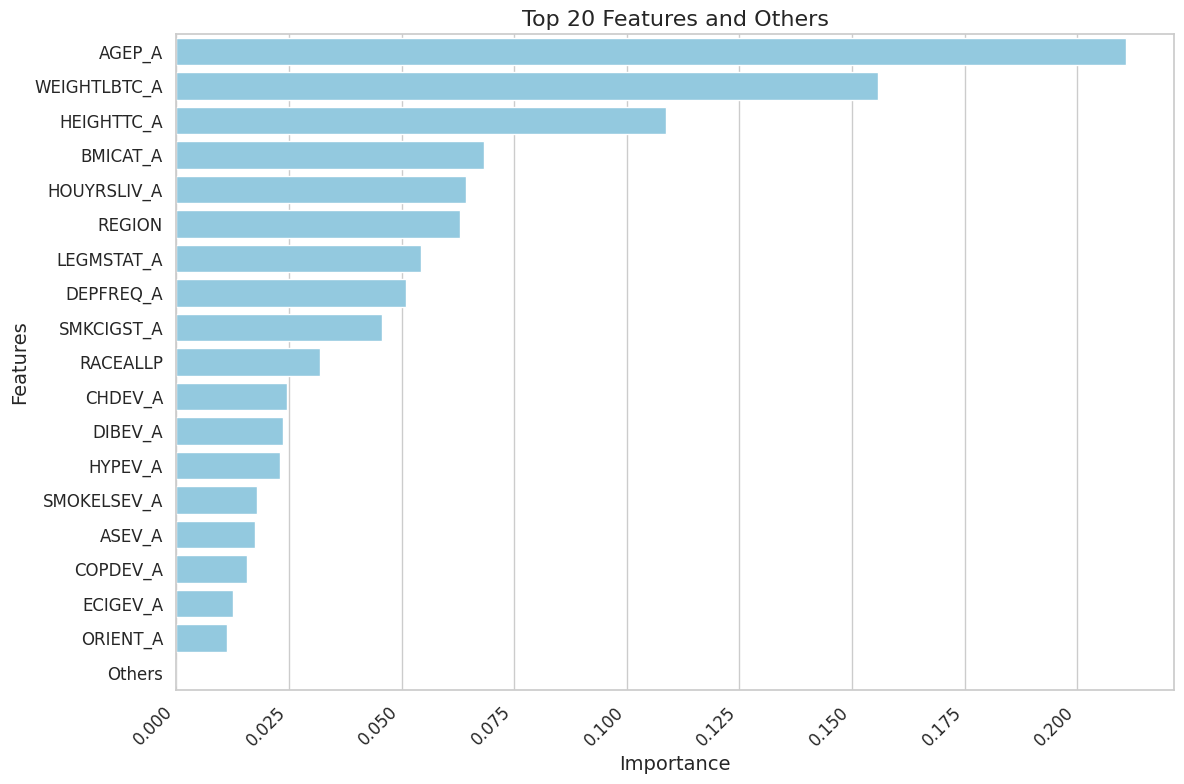

In [57]:
plot_top_features(feature_importance, top_n=20)

In [58]:
def add_cumulative_percentage(df):
    # Make sure the 'importance' column is numeric
    df['importance'] = pd.to_numeric(df['importance'], errors='coerce')

    # Calculate cumulative percentage
    df['cumulative_percentage'] = (df['importance'].cumsum() / df['importance'].sum()) * 100

    # Fill any NaN values with 0 in case there are missing values in 'importance' column
    df['cumulative_percentage'].fillna(0, inplace=True)

    return df

feature_importance = add_cumulative_percentage(feature_importance)

## Tuning Hyperparameters for better performance

In [59]:
# Define the Random Forest Classifier
rf_classifier = RandomForestClassifier(class_weight={1:3,2:1})

# Define the hyperparameters and their possible values for tuning
param_dist = {
    'criterion': ["gini", "entropy"],
    'n_estimators': [int(x) for x in np.linspace(start=50, stop=200, num=10)],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [40, 50, 60, 100, 200, 500],
    'min_samples_leaf': [1, 2, 4,8],
    'bootstrap': [True, False]
}

# Use F1 score as the scoring metric
scorer = make_scorer(f1_score, average='weighted')  # Adjust 'average' parameter as needed

# Use RandomizedSearchCV for hyperparameter tuning with F1 score

random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_dist, 
                                   n_iter=100, cv=5, scoring=scorer, n_jobs=-1, random_state=4212)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Print the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_rf_model = random_search.best_estimator_

# Evaluate the model on the test set using F1 score
y_pred = best_rf_model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')  # Adjust 'average' parameter as needed
print("Test F1 Score:", f1)

Best Hyperparameters: {'n_estimators': 166, 'min_samples_split': 40, 'min_samples_leaf': 2, 'max_depth': 30, 'criterion': 'entropy', 'bootstrap': False}
Test F1 Score: 0.7297150681519061


### Try GridSearchCV

In [60]:
print("Model performance after hyperparameters tuning")
# Make predictions on the training set
y_train_pred = best_rf_model.predict(X_train)

# Evaluate the model using classification report
print("Classification report on the training set")
print(classification_report(y_train, y_train_pred))

# Make predictions on the testing set
y_test_pred = best_rf_model.predict(X_test)

# Evaluate the model using classification report
print("Classification report on the testing set")
print(classification_report(y_test, y_test_pred))

Model performance after hyperparameters tuning


Classification report on the training set
              precision    recall  f1-score   support

         1.0       0.70      0.97      0.82      1514
         2.0       0.99      0.83      0.90      3666

    accuracy                           0.87      5180
   macro avg       0.84      0.90      0.86      5180
weighted avg       0.90      0.87      0.88      5180

Classification report on the testing set
              precision    recall  f1-score   support

         1.0       0.51      0.81      0.63       649
         2.0       0.90      0.68      0.77      1571

    accuracy                           0.72      2220
   macro avg       0.70      0.74      0.70      2220
weighted avg       0.78      0.72      0.73      2220



In [ ]:
## Add aucroc, add confusion matrix and add labels to them

In [ ]:
fpr, tpr, _ = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % test_auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()